# Custom satellites

In this example we'll change two most important parameters: inclination & altitude (by modifying mean motion).

![orbital elements](https://upload.wikimedia.org/wikipedia/commons/thumb/e/eb/Orbit1.svg/266px-Orbit1.svg.png)

Full documentation of satellite model parameters can be found in [Skyfield's EarthSatellite documentation](http://rhodesmill.org/skyfield/api-satellites.html#skyfield.sgp4lib.EarthSatellite)

In [1]:
import os
from skyfield.api import load
import numpy as np
from skyfield.api import load, EarthSatellite

## Load existing satellite from NORAD database

In [2]:
resource_url = 'http://celestrak.com/satcat/tle.php?CATNR=40299'

fname = 'tle_hodoyoshi_1.txt'
satellites = load.tle(resource_url, filename=fname, reload=False)

satellite = satellites['HODOYOSHI 1']
print(satellite)

EarthSatellite 'HODOYOSHI 1' number=40299 epoch=2018-10-24T12:03:08Z


In [3]:
print(satellite.epoch.utc_jpl())

A.D. 2018-Oct-24 12:03:08.2181 UT


## Modify parameters

In [4]:
print('Right ascension of ascending node: {:}'.format(np.rad2deg(satellite.model.nodeo)))
print('Inclination: {:}'.format(np.rad2deg(satellite.model.inclo)))
print('Mean motion: {:}'.format(satellite.model.no))

Right ascension of ascending node: 16.9494
Inclination: 97.3704
Mean motion: 0.06650074387028093


### Change right ascension of ascending node

In [5]:
satellite.model.nodeo = np.deg2rad(0)

### Change inclination

In [6]:
# change inclination to 15 degrees
satellite.model.inclo = np.deg2rad(170)

### Change altitude

Altitude is very strongly related to mean motion, which is one of the orbital elements.

To change it we need to know what is orbital period of a satellite.

$\large n={\frac {2\pi }{P}}$

$n$ - mean motion in radians per second

$P = 2\pi \sqrt{\frac{a^{3}}{\mu}}$

$a$ - major semi axis

$\mu = GM_{body}$ - Standard gravitational parameter

$G$ - Gravitational constant ($G \approx 6.674*10^{-11} N \cdot kg^{-2} \cdot m^{2}$)

$M_{body}$ - Body mass in kilograms



In [7]:
G_CONST = 6.674 * 10**-11
EARTH_MASS = 5.97237 * 10**24
EARTH_RADIUS = 6.371 * 10**6
MU_EARTH = G_CONST * EARTH_MASS

def orbital_period(mu_body, a):
    return 2 * np.pi * np.sqrt(np.power(a, 3) / mu_body)

# change altitude to 400 km (above Earth's surface)
a = 400
P = orbital_period(MU_EARTH, EARTH_RADIUS + (a * 10**3))
no = (np.pi * 2) / P # rad / s

satellite.model.no = no * 60 # rad / min

In [8]:
print('Orbital period: {:0.0f}h {:0.0f}m'.format(P // 3600, ((P % 3600) * 60) / 3600))
print('Revolutions per day: {:0.1f}'.format((3600 * 24) / P))

Orbital period: 1h 32m
Revolutions per day: 15.6


## Review parameters

In [9]:
print('Right ascension of ascending node: {:}'.format(np.rad2deg(satellite.model.nodeo)))
print('Inclination: {:}'.format(np.rad2deg(satellite.model.inclo)))
print('Mean motion: {:}'.format(satellite.model.no))

Right ascension of ascending node: 0.0
Inclination: 170.0
Mean motion: 0.06798897338362271


## Visualize ground path

In [15]:
from ground_path import ground_path
from plotting import plot_ground_path
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy
from datetime import datetime

In [16]:
# generate ground path
date_from = datetime(2018,8,1,0,0,0,0)
date_to = datetime(2018,8,2,0,0,0,0)
freq = 30 # generate data point every 30 seconds
df = ground_path(satellite, date_from, date_to, freq)
df.head()

,X,Y,Z,lat,lon,elevation,ascending,orbit
datetime,,,,,,,,
2018-08-01 00:00:00+00:00,-5538.966588,-3728.280370,1057.210556,8.969584,-95.382612,382.402806,True,0
2018-08-01 00:00:30+00:00,-5658.619044,-3538.285892,1074.391473,9.116438,-97.434775,382.111552,True,0
2018-08-01 00:01:00+00:00,-5771.997733,-3344.396538,1090.381360,9.253141,-99.488414,381.840803,True,0
2018-08-01 00:01:30+00:00,-5878.979291,-3146.826467,1105.162880,9.379530,-101.543443,381.591070,True,0
2018-08-01 00:02:00+00:00,-5979.447404,-2945.793688,1118.720024,9.495456,-103.599769,381.362834,True,0


In [17]:
df['orbit'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

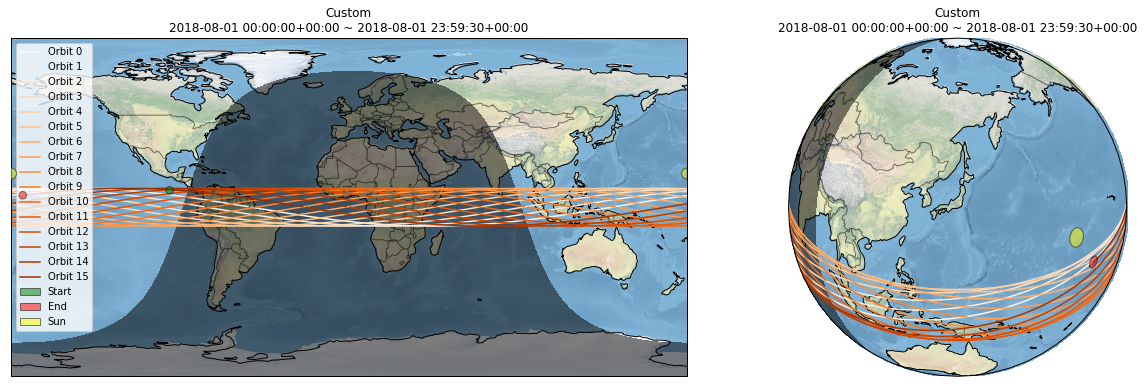

In [18]:
title = "Custom\n{:} ~ {:}".format(df.index.min(), df.index.max())

fig = plt.figure(figsize=(20,10))

# map projection
projection0 = cartopy.crs.PlateCarree()
projection1 = cartopy.crs.NearsidePerspective(central_longitude=139.0, central_latitude=35.0)

# object transformation
transform = cartopy.crs.Geodetic()

gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 

ax0 = plt.subplot(gs[0], projection=projection0)
plot_ground_path(ax0, df, transform=transform, cmap='Oranges')
ax0.set_title(title)
ax0.legend(loc='upper left')

ax1 = plt.subplot(gs[1], projection=projection1)
plot_ground_path(ax1, df, transform=transform, cmap='Oranges')
ax1.set_title(title)

plt.savefig('ground_path_custom.jpg')
plt.show()

## Sources

- http://rhodesmill.org/skyfield/api-satellites.html#skyfield.sgp4lib.EarthSatellite
- https://en.wikipedia.org/wiki/Two-line_element_set
- https://en.wikipedia.org/wiki/Orbital_speed
- https://en.wikipedia.org/wiki/Mean_motion